In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter, defaultdict
from math import log2

In [3]:
# === Naive Bayes From Scratch ===
class NaiveBayes:
    def fit(self, X, y):
        self.classes = np.unique(y)
        self.priors = {c: sum(y == c) / len(y) for c in self.classes}
        self.means = {}
        self.vars = {}
        for c in self.classes:
            X_c = X[y == c]
            self.means[c] = np.mean(X_c, axis=0)
            self.vars[c] = np.var(X_c, axis=0) + 1e-6  # Avoid divide by zero

    def gaussian_prob(self, x, mean, var):
        return np.exp(- ((x - mean) ** 2) / (2 * var)) / np.sqrt(2 * np.pi * var)

    def predict(self, X):
        predictions = []
        for x in X:
            posteriors = {}
            for c in self.classes:
                prior = log2(self.priors[c])
                conditional = np.sum(np.log2(self.gaussian_prob(x, self.means[c], self.vars[c])))
                posteriors[c] = prior + conditional
            predictions.append(max(posteriors, key=posteriors.get))
        return np.array(predictions)


In [4]:
# === Decision Tree From Scratch ===
class DecisionTree:
    def __init__(self, max_depth=5):
        self.max_depth = max_depth

    def entropy(self, y):
        counts = np.bincount(y)
        probs = counts / len(y)
        return -np.sum([p * log2(p + 1e-9) for p in probs if p > 0])

    def best_split(self, X, y):
        best_gain, best_feature, best_thresh = 0, None, None
        for feature in range(X.shape[1]):
            thresholds = np.unique(X[:, feature])
            for thresh in thresholds:
                left = y[X[:, feature] <= thresh]
                right = y[X[:, feature] > thresh]
                if len(left) == 0 or len(right) == 0:
                    continue
                gain = self.entropy(y) - (len(left)/len(y))*self.entropy(left) - (len(right)/len(y))*self.entropy(right)
                if gain > best_gain:
                    best_gain = gain
                    best_feature = feature
                    best_thresh = thresh
        return best_feature, best_thresh

    def build_tree(self, X, y, depth=0):
        if len(set(y)) == 1 or depth == self.max_depth:
            return Counter(y).most_common(1)[0][0]
        feature, thresh = self.best_split(X, y)
        if feature is None:
            return Counter(y).most_common(1)[0][0]
        left_indices = X[:, feature] <= thresh
        right_indices = X[:, feature] > thresh
        return {
            'feature': feature,
            'threshold': thresh,
            'left': self.build_tree(X[left_indices], y[left_indices], depth+1),
            'right': self.build_tree(X[right_indices], y[right_indices], depth+1)
        }

    def fit(self, X, y):
        self.tree = self.build_tree(X, y)

    def predict_one(self, x, node):
        if not isinstance(node, dict):
            return node
        if x[node['feature']] <= node['threshold']:
            return self.predict_one(x, node['left'])
        else:
            return self.predict_one(x, node['right'])

    def predict(self, X):
        return np.array([self.predict_one(x, self.tree) for x in X])

In [5]:
datasets = {
    "iris": "datasets/iris.csv",
    "diabetes": "datasets/diabetes.csv",
    "wine": "datasets/wine.csv",
    "seeds": "datasets/seeds.csv",
    "glass": "datasets/glass.csv",
    "parkinsons": "datasets/parkinsons.csv",
    "breast_cancer": "datasets/breast_cancer.csv"
}


In [6]:

# === Utility: Evaluation Metrics ===
def accuracy(y_true, y_pred):
    return sum(y1 == y2 for y1, y2 in zip(y_true, y_pred)) / len(y_true)

def precision(y_true, y_pred):
    classes = set(y_true)
    total = 0
    for cls in classes:
        tp = sum((yt == cls and yp == cls) for yt, yp in zip(y_true, y_pred))
        fp = sum((yt != cls and yp == cls) for yt, yp in zip(y_true, y_pred))
        total += tp / (tp + fp + 1e-9)
    return total / len(classes)

def recall(y_true, y_pred):
    classes = set(y_true)
    total = 0
    for cls in classes:
        tp = sum((yt == cls and yp == cls) for yt, yp in zip(y_true, y_pred))
        fn = sum((yt == cls and yp != cls) for yt, yp in zip(y_true, y_pred))
        total += tp / (tp + fn + 1e-9)
    return total / len(classes)

def f1_score(y_true, y_pred):
    p = precision(y_true, y_pred)
    r = recall(y_true, y_pred)
    return 2 * p * r / (p + r + 1e-9)


C:\Users\user\AppData\Local\Temp\ipykernel_5856\2289631459.py:22: RuntimeWarning: divide by zero encountered in log2
  conditional = np.sum(np.log2(self.gaussian_prob(x, self.means[c], self.vars[c])))
C:\Users\user\AppData\Local\Temp\ipykernel_5856\2289631459.py:22: RuntimeWarning: divide by zero encountered in log2
  conditional = np.sum(np.log2(self.gaussian_prob(x, self.means[c], self.vars[c])))
C:\Users\user\AppData\Local\Temp\ipykernel_5856\2289631459.py:22: RuntimeWarning: divide by zero encountered in log2
  conditional = np.sum(np.log2(self.gaussian_prob(x, self.means[c], self.vars[c])))
C:\Users\user\AppData\Local\Temp\ipykernel_5856\2289631459.py:22: RuntimeWarning: divide by zero encountered in log2
  conditional = np.sum(np.log2(self.gaussian_prob(x, self.means[c], self.vars[c])))
C:\Users\user\AppData\Local\Temp\ipykernel_5856\2289631459.py:22: RuntimeWarning: divide by zero encountered in log2
  conditional = np.sum(np.log2(self.gaussian_prob(x, self.means[c], self.vars[c

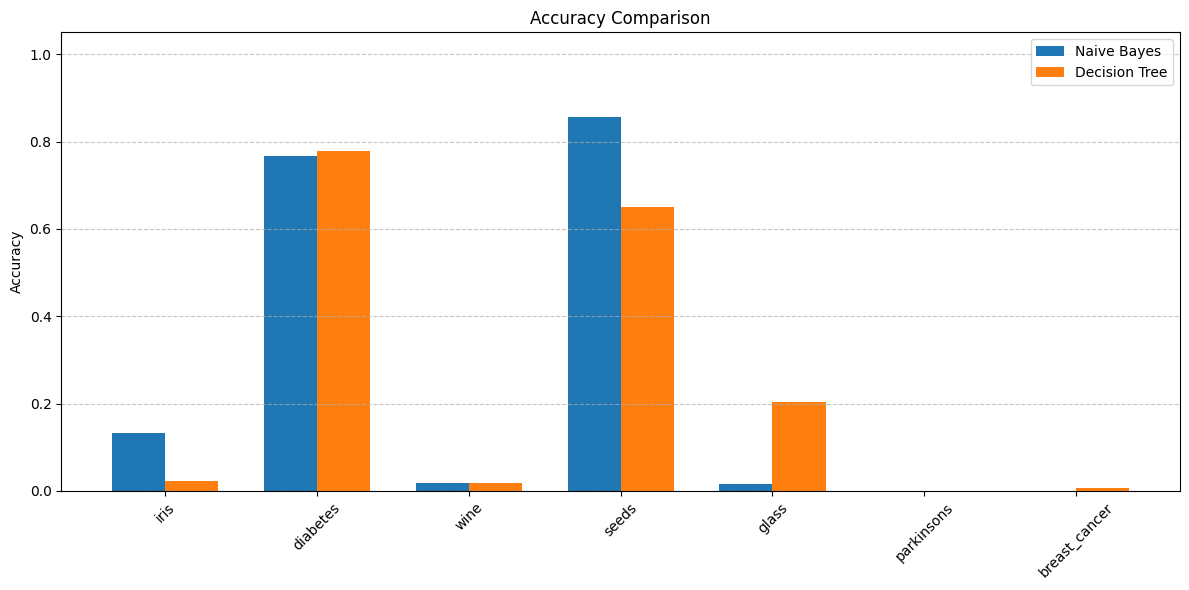

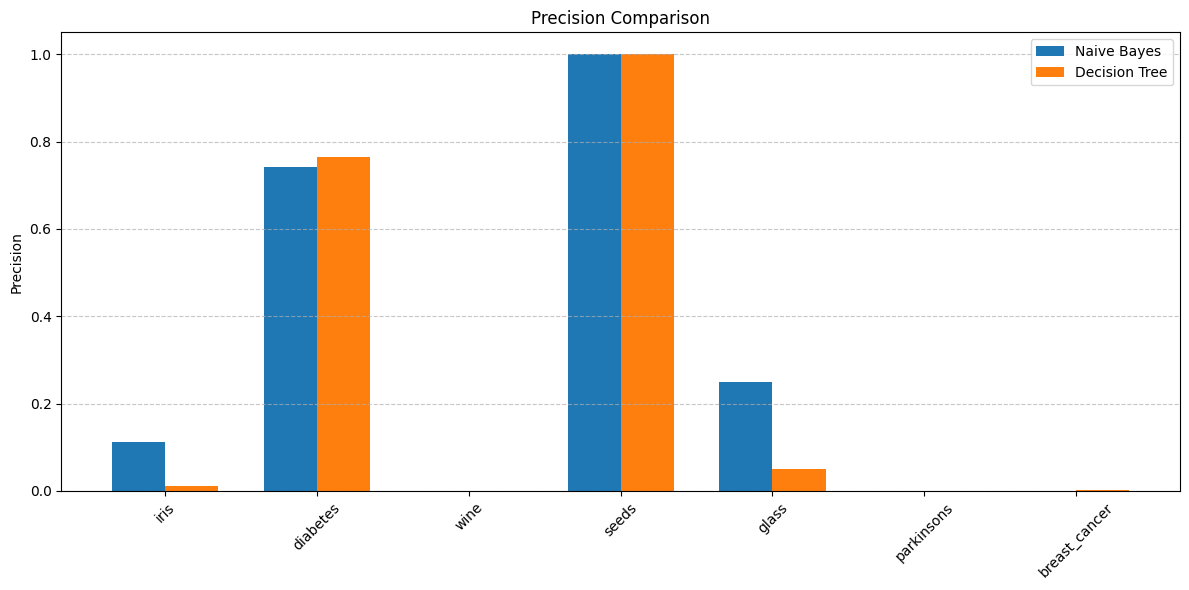

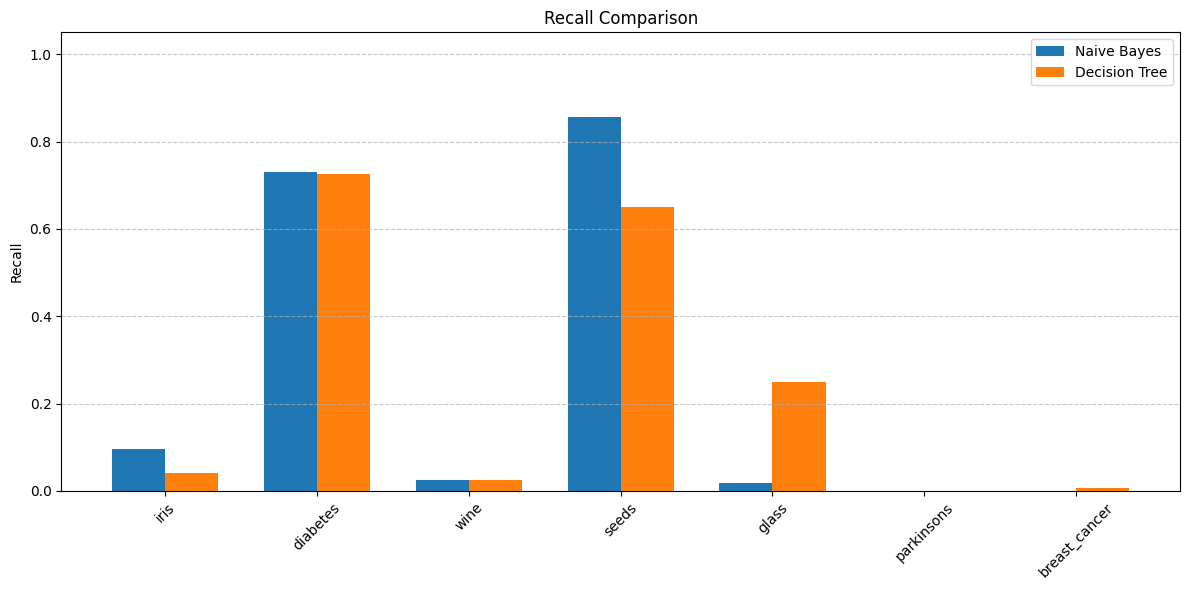

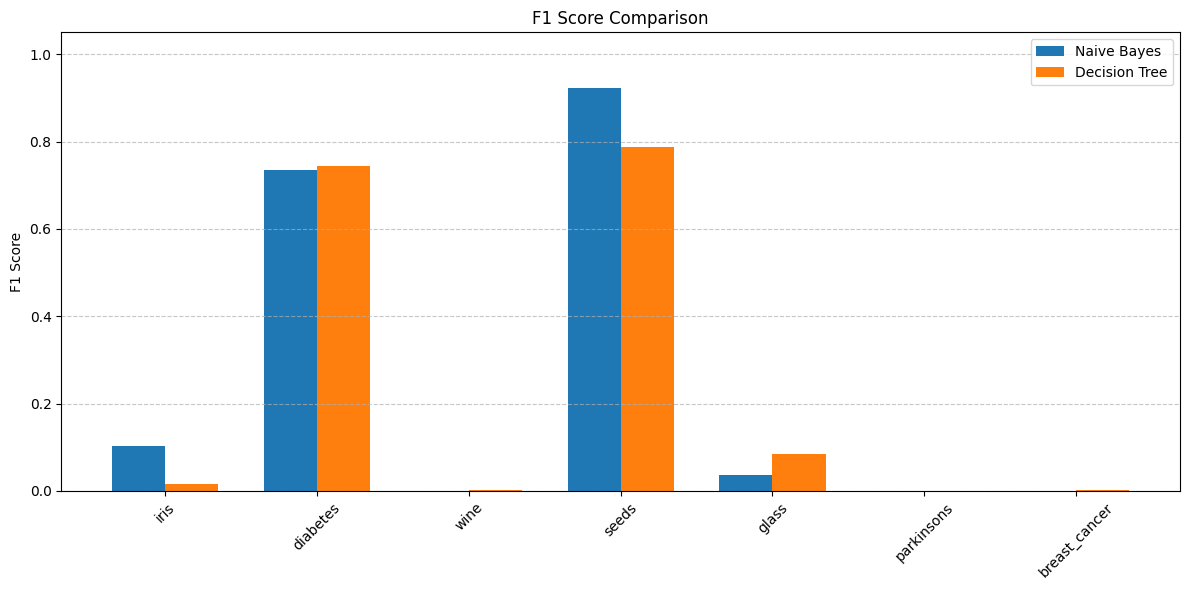

In [11]:

results = []

# === Experiment Loop ===
for name, file in datasets.items():
    df = pd.read_csv(file)

    # Auto-detect last column as target
    X = df.iloc[:, :-1].values
    y_raw = df.iloc[:, -1]
    y = pd.factorize(y_raw)[0]


    # X = (X - X.mean(axis=0)) / (X.std(axis=0) + 1e-9)
    # X = df.iloc[:, :-1].to_numpy(dtype=float)
    X = df.select_dtypes(include=[np.number]).iloc[:, :-1].to_numpy()
    y = pd.factorize(y_raw)[0]


    # Split data
    split = int(0.7 * len(X))
    X_train, X_test = X[:split], X[split:]
    y_train, y_test = y[:split], y[split:]

    # Naive Bayes
    nb = NaiveBayes()
    nb.fit(X_train, y_train)
    y_pred_nb = nb.predict(X_test)

    # Decision Tree
    dt = DecisionTree(max_depth=5)
    dt.fit(X_train, y_train)
    y_pred_dt = dt.predict(X_test)

    for model_name, y_pred in [("Naive Bayes", y_pred_nb), ("Decision Tree", y_pred_dt)]:
        results.append({
            "Dataset": name,
            "Algorithm": model_name,
            "Accuracy": accuracy(y_test, y_pred),
            "Precision": precision(y_test, y_pred),
            "Recall": recall(y_test, y_pred),
            "F1 Score": f1_score(y_test, y_pred)
        })

# # === Plotting Results ===
# results_df = pd.DataFrame(results)

# metrics = ["Accuracy", "Precision", "Recall", "F1 Score"]

# for metric in metrics:
#     plt.figure(figsize=(10, 5))
#     for algo in ["Naive Bayes", "Decision Tree"]:
#         subset = results_df[results_df["Algorithm"] == algo]
#         plt.plot(subset["Dataset"], subset[metric], marker='o', label=algo)
#     plt.title(f"{metric} Comparison")
#     plt.ylabel(metric)
#     plt.xticks(rotation=45)
#     plt.ylim(0, 1.05)
#     plt.legend()
#     plt.grid(True)
#     plt.tight_layout()
#     plt.show()


# === Plotting Results as Histograms ===
results_df = pd.DataFrame(results)

metrics = ["Accuracy", "Precision", "Recall", "F1 Score"]
algorithms = ["Naive Bayes", "Decision Tree"]
datasets_list = list(results_df["Dataset"].unique())

x = np.arange(len(datasets_list))  # x locations for groups
width = 0.35  # width of the bars

for metric in metrics:
    plt.figure(figsize=(12, 6))

    for i, algo in enumerate(algorithms):
        subset = results_df[results_df["Algorithm"] == algo]
        metric_values = subset.set_index("Dataset").loc[datasets_list][metric]
        plt.bar(x + i*width, metric_values, width=width, label=algo)

    plt.title(f"{metric} Comparison")
    plt.ylabel(metric)
    plt.xticks(x + width / 2, datasets_list, rotation=45)
    plt.ylim(0, 1.05)
    plt.legend()
    plt.grid(axis="y", linestyle="--", alpha=0.7)
    plt.tight_layout()
    plt.show()